After exploring data, engineer it, training and tuning models, time has come to analyze results and compare model performance.

After displaying a bar graph of the model scores to find the best performer, I will explore the way they react when prediction is far from the value predicted by the *DummyRegressor*. This will help conclude about the bias I've suspected, is it real or not. Maybe I'll get a good surprise...


In [1]:
# Load my_utils.ipynb in Notebook
from ipynb.fs.full.my_utils import *

Opening connection to database
Add pythagore() function to SQLite engine
Fraction of the dataset used to train models: 10.00%
my_utils library loaded :-)


# Load full *X/y* validation set only

For prediction score, I will use the complete validation dataset by setting the *frac* parameter to 1

> Note: We won't use training dataset in this Notebook, I do keep only X and y validation set

In [2]:
# Load X and y validation vector
_, _, X, y=load_Xy(frac=1)
print("Shape of the validation features :", X.shape)
print("Shape of the validation vector   : ", y.shape)


Shape of the validation features : (285283, 38)
Shape of the validation vector   :  (285283,)


Nice, 285'283 travel for speed prediction evaluation. Let's go !

# Load models and build a dataframe with their characteristics

I will use the trained models saved on disk to predict values using the *validation* dataset. Those prediction will be used to calculate the *Mean Absolute Error* (in km/h) and the *Mean Absolute Percent Error* (in %) for each model.

I'll then store this *MAE* and *MAPE* in a dataframe, along with the time spent in the grid search process to find their best hyperparameters.

## Compute prediction for each model

After loading each previously fitted models, I will evaluate their prediction results using the *X* validation features loaded previously.

The result will be stored in a *pandas.DataFrame*, the first column being the *y* validation values loaded from dataset, and next columns being the results of the column name model.

In [3]:
model_list=[ 'dummy', 'ridge', 'ridge-pca90', 'ridge-pca80', 'kneighbors', 'random-forest', 'mlp']

# Initialize dict with y validation values
predictions={
    'y': y
}

for i in model_list:
    print("Model", i)
    model=load_model(i)
    print("  Predict values...")
    predictions[i]=list(model.predict(X))
    print("  Process terminated.")

predict=pd.DataFrame(predictions)

Model dummy
Loading model from  ./data/model-dummy.sav
Model loaded using pickle()
  Predict values...
  Process terminated.
Model ridge
Loading model from  ./data/model-ridge.sav
Model loaded using pickle()
  Predict values...
  Process terminated.
Model ridge-pca90
Loading model from  ./data/model-ridge-pca90.sav
Model loaded using pickle()
  Predict values...
  Process terminated.
Model ridge-pca80
Loading model from  ./data/model-ridge-pca80.sav
Model loaded using pickle()
  Predict values...
  Process terminated.
Model kneighbors
Loading model from  ./data/model-kneighbors.sav
Model loaded using pickle()
  Predict values...
  Process terminated.
Model random-forest
Loading model from  ./data/model-random-forest.sav
Model loaded using pickle()
  Predict values...
  Process terminated.
Model mlp
Loading model from  ./data/model-mlp.sav
Model loaded using pickle()
  Predict values...
  Process terminated.


In [4]:
# Let's display first lines of this prediction dataset
predict.head(3)

,y,dummy,ridge,ridge-pca90,ridge-pca80,kneighbors,random-forest,mlp
0,1.547166,1.108545,1.473139,1.534104,1.453226,1.453658,1.517538,1.437138
1,0.932664,1.108545,1.050087,1.050057,1.054383,1.056632,0.991835,1.041009
2,0.972171,1.108545,1.187904,1.110241,1.127601,1.083668,1.005874,1.183418


### Prediction in km per hour

Remember, the value we obtain here are *np.log10(km/h)* values. 

Let's do a copy of this *predict* dataset converting values to km/h

In [5]:
# Do a copy of the dataset
predict_kmh=predict.copy()

# Compute values in km/h
predict_kmh=10**predict_kmh

# Describe the result
predict_kmh.describe().astype('int')

,y,dummy,ridge,ridge-pca90,ridge-pca80,kneighbors,random-forest,mlp
count,285283,285283,285283,285283,285283,285283,285283,285283
mean,14,12,13,13,13,13,13,13
std,7,0,4,4,4,4,5,5
min,3,12,3,3,4,4,3,2
25%,9,12,10,10,10,10,9,9
50%,12,12,12,12,12,12,12,12
75%,17,12,15,14,14,15,16,16
max,49,12,58,79,83,40,46,65


Looking at the previous result, I can confirm the suspicion I have concerning the dataset Bias.

The *50%* value for all the models are nearly equal to the *50%* value of the *y* validation set. And if we look at the *75%* and *max*, we can confirm that there is quite important difference.

Except maybe for the *random-forest* models that seems to reserve good surprises.

Let's continue with some graphs to explore the performance of each models.

## Calculate MAE and MAPE, append training time

As explained before, I will build a *pd.DataFrame* object that will contains, for each models, its MAE, MAPE and grid search time in seconds.

This dataset will be used later to draw some graphs.

In [6]:
# Calculate MAE and MAPE for each model and store it in arrays
mae_result=[]
mape_result=[]
for col in model_list:
    mae_result.append(mae(predict[col], predict['y']))
    mape_result.append(mape(predict[col], predict['y']))
    
# Grid search time in seconds has been retrieved manually from previous Notebooks
# Order: [ 'dummy', 'ridge', 'ridge-pca90', 'ridge-pca80', 'kneighbors', 'random-forest', 'mlp']
grid_time=[4, 2.5*60, 4.5*60, 4.3*60, 250.1*60, 62.9*60, 199.9*60]

# Build dataframe
model_results=pd.DataFrame(
    {
        'model': model_list,
        'mae': mae_result,
        'mape': mape_result,
        'grid_time': grid_time
    }
)

# display dataframe
model_results

,model,mae,mape,grid_time
0,dummy,1.479496,84.006025,4.0
1,ridge,1.359001,87.474777,150.0
2,ridge-pca90,1.375086,86.994327,270.0
3,ridge-pca80,1.386903,86.644931,258.0
4,kneighbors,1.343402,87.946178,15006.0
5,random-forest,1.214454,92.066561,3774.0
6,mlp,1.292135,89.534899,11994.0


# A bar graph to compare model performance

The most simple way to determine the best model trained: Use a bar graph to display their *Mean Absolute Percent Error*

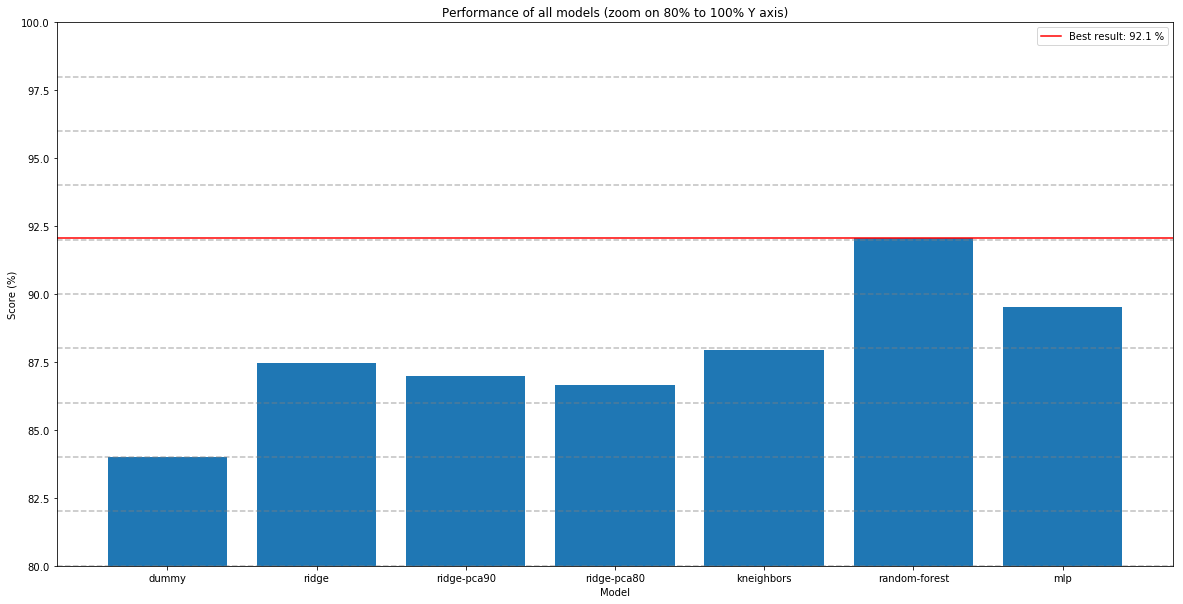

In [7]:
def draw_bar_graph(df=model_results,
                   column='mape',
                   ylabel='Score (%)',
                   xlabel='Model',
                   title='Performance of all models (zoom on 80% to 100% Y axis)',
                   ylim=[80,100],
                   best_label='Best result',
                   dash_line=[80,100,2]
                  ) -> None:
    # get MAPE from model results dataset
    mean_percent=df[column]

    # Calculate x_values range (trick to use when X-axis is made of strings)
    x_values = list(range(len(mean_percent)))

    # Set figure size
    plt.figure(figsize=(20,10))

    # Make a bar chart
    plt.bar(x_values, mean_percent)

    # Tick labels for x axis, replacing range values
    plt.xticks(x_values, model_list)#, rotation='vertical')

    # Draw horizontal line for best result
    plt.axhline(y=max(mean_percent), color='r', label=best_label)

    # Draw dashed if defined
    if dash_line != None:
        for i in list(range(*dash_line)):
            plt.axhline(y=i, color='grey', linestyle='--', alpha=0.5)

    # Axis labels, legend and title
    if ylim!= None:
        plt.ylim(*ylim)
    plt.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()


draw_bar_graph(best_label='Best result: {:.1f} %'.format(max(model_results['mape'])))

Wow... What a good surprise. *RandomForestRegressor* seems to beat other models. That's good news.

## What can we say from the previous graph ?

First, *dummy* regressor performs not so bad, that's a first signal about the bias I suspect. The way I've configured the *DummyRegressor* model, it always predict the mean of the training set, and the training set has a huge concentration of travels between 10 and 15 km/h. Predicting a travel trip in NYC at 12 km/h (this is the prediction done by the *DummyRegressor*) has good chance to be right.

Second, all models trained performs better than the *dummy* one. Better, but not so much.

Third, *Ridge* regressor combined with *PCA()* shows a slightly lower performance when percentage of primary component decrease. This is not a surprise as *PCA* is made to reduce computing time against prediction performance.

Fourth, we should focus on *random-forest* as it has a significative better performance than other models (near of 95%). Does that mean that the bias in dataset has been handled by this model ? I'll see that later...

Fifth, the grid search time is clearly not correlated to the model performance. This can be observed on the next graph.

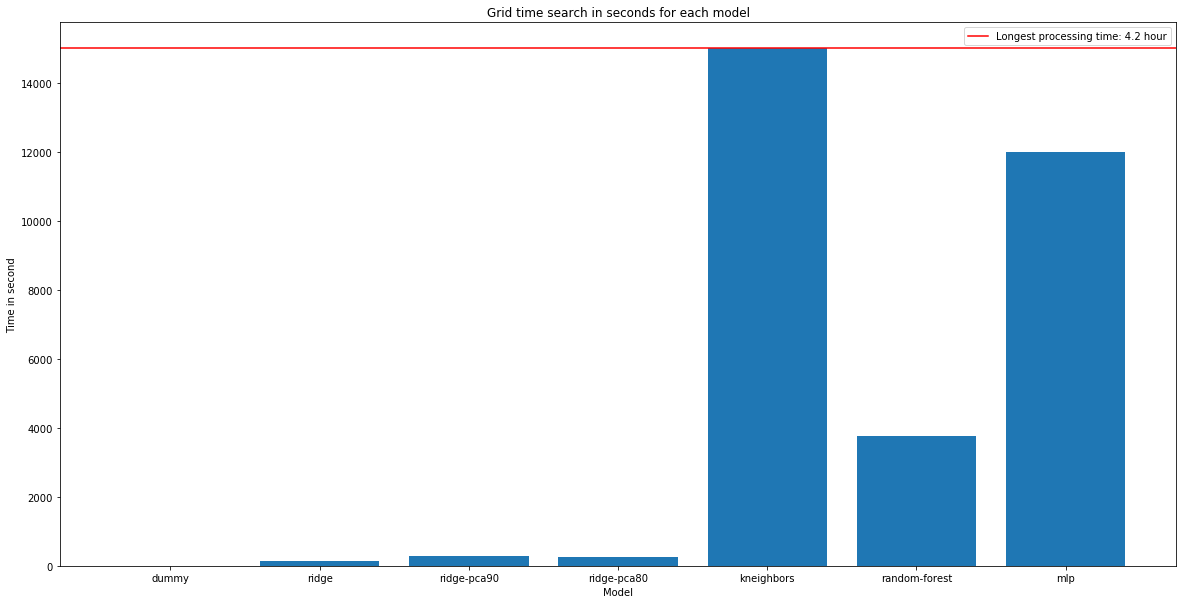

In [8]:
# Draw grid search time bar graph
best_label='Longest processing time: {:.1f} hour'.format(max(model_results['grid_time'])/3600)
draw_bar_graph(column='grid_time',
               ylabel='Time in second',
               title='Grid time search in seconds for each model',
               best_label=best_label,
               ylim=None,
               dash_line=None
              )

*kneighbors* took nearly 4 times more time to be trained than *random-forest*, *mlp* took 3 times more time.

Another reason to see the *RandomForestRegressor* as the best model to choose to predict Taxi trip in NYC.

> Note: Grid search might have not been done with the same iterations, values presented here could be optimized by reducing grid parameters scope without changing results. Anyway, it's the time I've spent in grid search and it shows the efficiency at seeking the best parameters of the *RandomForestRegressor*.

# Some more graphs

## Scatter plot with polyfit

The following graph represent polynomial regression of degree=2 of scatter plots made between the real values (*y*) and their predictions, one regression per models.

On the X-axis is the real *y* value, on the Y-axis is the predicted one by models.

I've added a green line which represent the perfect prediction *y=prediction* as a baseline. The nearer model regression line is, the better is the performance score.

> Note 1: To make the graph easy to read, I do not add scatter plots, only regression curves.

> Note 2: Remember, value here are *np.log10(km/h).

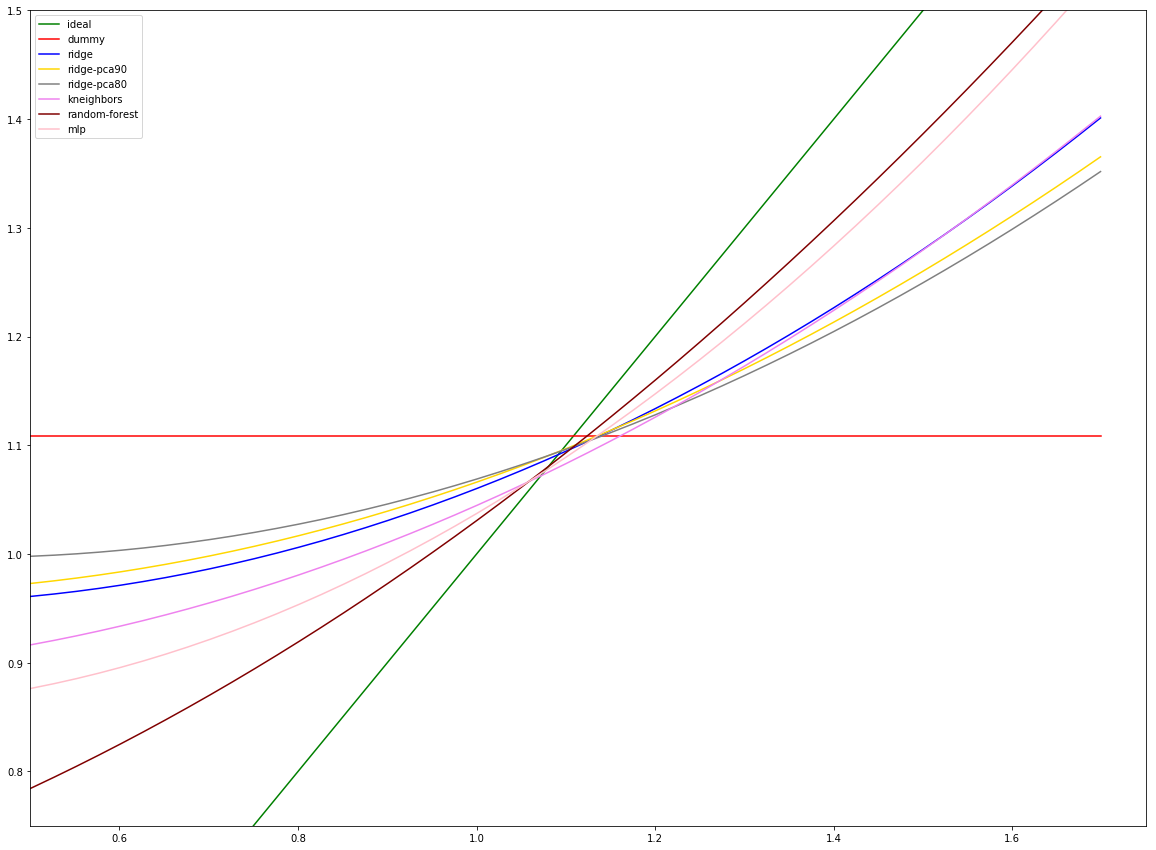

In [9]:
def draw_poly_regression(df, degree=2, figsize=(8,8), xlim=(0.5,1.75), ylim=(0.75,1.5), model_list=model_list) -> None :

    plt.figure(figsize=figsize)

    plt.plot([0,2], [0, 2], label='ideal', color='green')

    y=df['y']

    for col, color in zip(model_list, ['red', 'blue', 'gold','grey', 'violet', 'maroon', 'pink']):

        y_pred=df[col]

        coef=np.polyfit(y,y_pred,degree)

        x_values=np.linspace(y.min(), y.max())
        y_values=np.polyval(coef, x_values)

        plt.plot(x_values, y_values, label=col, color=color)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend()
    plt.show()

draw_poly_regression(predict, figsize=(20,15))

Again, this graph confirms that *RandomForestRegressor()* is the best choice. It's polynomial regression curve is the closest one to the perfect curve (the green one).


## Confirm bias with *MAPE* per speed interval

To definitely conclude on the reality of the bias and the fact that *RandomForestRegressor* model beats this bias, I'll plot, for each model, a bar graph of the performance reached per speed interval (the same graph used in the [Ridge Regressor Notebook](31.Gradient%20Descent%20Based%20-%20Ridge%20Regressor.ipynb).

> Note: I will draw bargraph for *ridge-pca80*, *mlp* and *random-forest* predictions only for better graph clarity

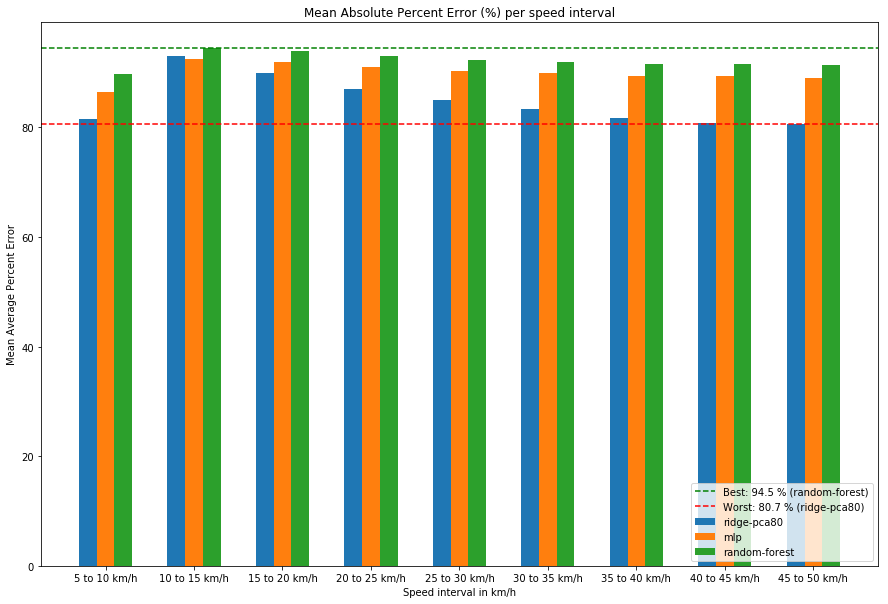

In [15]:
draw_mape_per_speed_interval(predict, columns=['ridge-pca80', 'mlp','random-forest'], barwidth=1, figsize=(15,10))

Looking at this bargraph, it's now clear that *RandomForest* performs more equally on each speed interval, where *RidgePCA(0.8)* doesn't.

Another proof that *RandomForest* model was able to handle the dataset bias better than other models.


# Conclusion

## The *RandomForestRegressor* is the right choice.

Remember the problem I'd like to solve in this project:

**What are the Taxi travel speed prevision for New-York City (NYC) depending on the travel characteristics and weather forecast ?**

The trained *RandomForestRegressor* provides an average right prediction score of 95%, and has been able to manage the dataset bias which consist of having much more Taxi travels in the speed interval of 10 to 15 km/h compared to other intervals. This lead the model to be efficient whatever the prediction speed is.


## Confirm with seaborn *regplot*

One good representation of the performance of the *RandomForest* model is using a [Seaborn.regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html).

This graph shows how the *y* values and *prediction* do fit closely the perfect line.


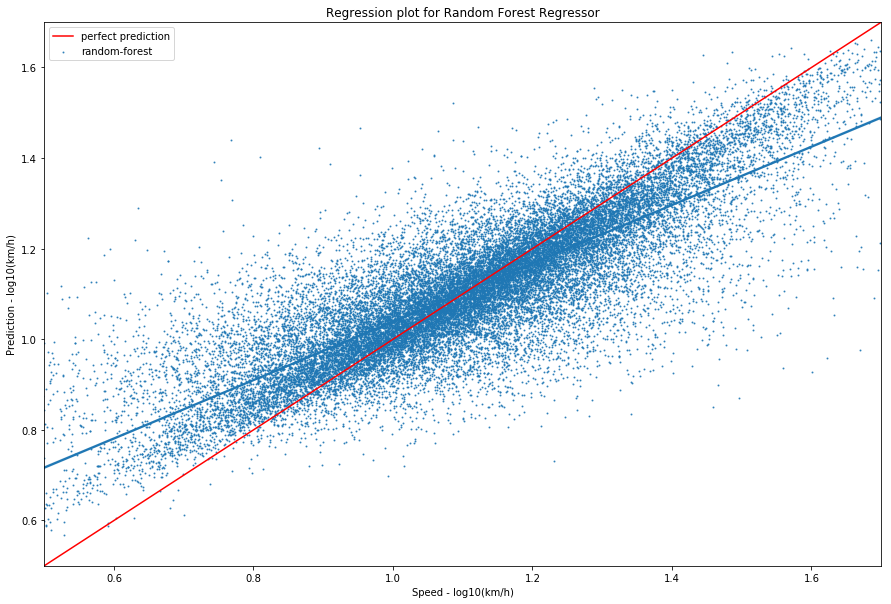

In [11]:
# Set figure size
plt.figure(figsize=(15,10))

# Get sample for better graph look
df=predict.sample(frac=0.1)

# draw seaborn.regplot
sns.regplot(df['y'], df['random-forest'], fit_reg=True, scatter_kws={"s": 1}, label='random-forest')

# draw perfect prediction line
plt.plot([0,2], [0, 2], label='perfect prediction', color='red')

# title and axis labels
plt.title("Regression plot for Random Forest Regressor")
plt.xlabel('Speed - log10(km/h)')
plt.xlim(0.5, 1.7)
plt.ylabel('Prediction - log10(km/h)')
plt.ylim(0.5,1.7)

# display legend and graph
plt.legend()
plt.show()

## Why is that model the best one ?

Looking back to the *RandomForest* model exploration made in previous [Notebook](33.Category%20Based%20-%20RandomForestRegressor.ipynb), I've found that the most important feature found by the model to predict values is the *travel distance*.

Altough, I could suppose that if the distance is high, then the travel course starts or ends far from the town center, which then might implies a higher travel speed (cars goes faster outside of town than in town center).

I should re-explore the dataset to confirm this, and maybe engineer a new feature like *How far pickup and dropoff locations are from town center* to help other models beat the bias.

But that would be another story for another project... ;-)

# Thanks...

...to all members of the [EPFL Learn Extension School team](https://www.extensionschool.ch/about/our-team), for this wonderful Machine Learning journey I've spent with all of you, it was really a pleasure.

Special dedicace to my Capstone project Course Instructor [Michael Notter](https://www.linkedin.com/in/michael-notter-5542b464/?originalSubdomain=ch)

Hope you'll find the same pleasure reading my project :-)

See you soon...

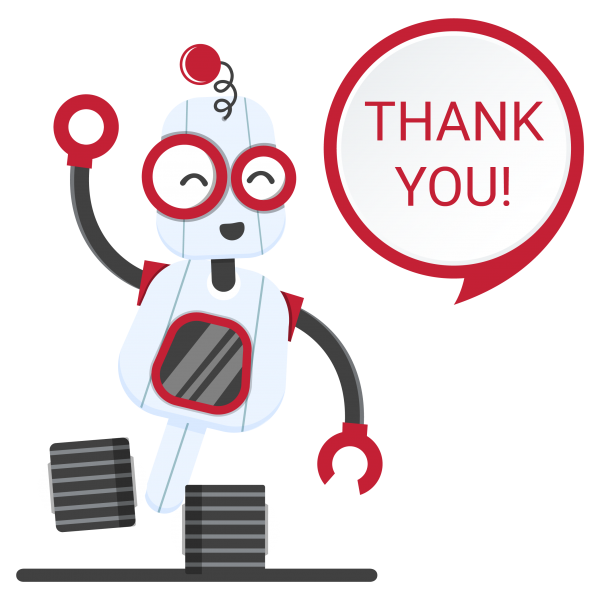

In [12]:
img=Image.open(os.path.join(IMG_PATH, 'thank-you.png'))
img.thumbnail([600,1000]);img